# installations

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


# uploading data

In [2]:
import pandas as pd

# Use raw string (r'...') to avoid issues with backslashes in Windows paths
file_path = r'FilteredData100.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Preview the first few rows
df.head()


,Y1,Y2,Y,Domain,area,keywords,Abstract
0,0,12,12,CS,Symbolic computation,(2+1)-dimensional non-linear optical waves; e...,(2 + 1)-dimensional non-linear optical waves t...
1,5,2,74,Medical,Alzheimer's Disease,Aging; Tau; Amyloid; PET; Alzheimer's disease...,(beta-amyloid (A beta) and tau pathology becom...
2,4,7,68,Civil,Green Building,LED lighting system; PV system; Distributed l...,(D)ecreasing of energy consumption and environ...
3,1,10,26,ECE,Electric motor,NdFeB magnets; Electric motor; Electric vehic...,(Hybrid) electric vehicles are assumed to play...
4,5,43,115,Medical,Parkinson's Disease,Parkinson's disease; dyskinesia; adenosine A(...,"(L)-3,4-Dihydroxyphenylalanine ((L)-DOPA) rema..."


In [3]:
import os, random, numpy as np, pandas as pd, torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
import evaluate

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

In [5]:
SEED = 42

## TF-IDF With XGBoost

In [6]:
# Two-step 70/15/15 split on 'area'
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Domain"],
    random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["Domain"],
    random_state=SEED
)

### On Domain and Area:

In [10]:
def run_ngram_experiment(ngram_range, train_df, val_df, test_df, label_encoder, label_column, seed=SEED):
    print(f"\n=== Evaluating on label column: '{label_column}' | N-gram range: {ngram_range} ===")

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=1000000)
    X_train = vectorizer.fit_transform(train_df["Abstract"])
    X_val   = vectorizer.transform(val_df["Abstract"])

    # Encode labels
    y_train = label_encoder.fit_transform(train_df[label_column])
    y_val   = label_encoder.transform(val_df[label_column])

    # Train model
    model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Evaluate on validation
    val_preds = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, val_preds, target_names=label_encoder.classes_))


Lowercases the text

Tokenizes using a regular expression: words of 2+ characters (\b\w\w+\b)

Removes punctuation

Builds unigrams & bigrams from the tokens

In [ ]:
label_encoder = LabelEncoder()
for label_col in ["Domain", "area"]:
    for ngram_range in [(1, 1), (2, 2), (1, 2)]:
        run_ngram_experiment(ngram_range, train_df, val_df, test_df, label_encoder, label_col)


=== Evaluating on label column: 'Domain' | N-gram range: (1, 1) ===


/home/shirbern/.conda/envs/shir_env_22_may/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:04:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.8786
Validation Classification Report:
               precision    recall  f1-score   support

          CS        0.89      0.93      0.91       971
       Civil        0.91      0.87      0.89       633
         ECE        0.92      0.90      0.91       807
         MAE        0.89      0.86      0.88       495
     Medical        0.86      0.90      0.88      2165
 Psychology         0.86      0.83      0.84      1071
biochemistry        0.87      0.83      0.85       851

     accuracy                           0.88      6993
    macro avg       0.89      0.87      0.88      6993
 weighted avg       0.88      0.88      0.88      6993


=== Evaluating on label column: 'Domain' | N-gram range: (2, 2) ===


/home/shirbern/.conda/envs/shir_env_22_may/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:09:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.8268
Validation Classification Report:
               precision    recall  f1-score   support

          CS        0.88      0.85      0.86       971
       Civil        0.94      0.80      0.86       633
         ECE        0.87      0.87      0.87       807
         MAE        0.91      0.77      0.83       495
     Medical        0.75      0.91      0.82      2165
 Psychology         0.83      0.71      0.77      1071
biochemistry        0.88      0.74      0.80       851

     accuracy                           0.83      6993
    macro avg       0.86      0.81      0.83      6993
 weighted avg       0.84      0.83      0.83      6993


=== Evaluating on label column: 'Domain' | N-gram range: (1, 2) ===


/home/shirbern/.conda/envs/shir_env_22_may/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:19:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.8899
Validation Classification Report:
               precision    recall  f1-score   support

          CS        0.92      0.93      0.92       971
       Civil        0.93      0.88      0.91       633
         ECE        0.93      0.94      0.93       807
         MAE        0.90      0.88      0.89       495
     Medical        0.86      0.91      0.89      2165
 Psychology         0.87      0.84      0.85      1071
biochemistry        0.88      0.82      0.85       851

     accuracy                           0.89      6993
    macro avg       0.90      0.89      0.89      6993
 weighted avg       0.89      0.89      0.89      6993


=== Evaluating on label column: 'area' | N-gram range: (1, 1) ===


/home/shirbern/.conda/envs/shir_env_22_may/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:34:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7616
Validation Classification Report:
                                    precision    recall  f1-score   support

                       Addiction         0.60      0.50      0.55        42
                Algorithm design         0.63      0.67      0.65        57
                       Allergies         0.91      0.89      0.90        55
             Alzheimer's Disease         0.77      0.87      0.82        54
            Ambient Intelligence         0.79      0.88      0.83        56
        Analog signal processing         0.80      0.81      0.81        64
          Ankylosing Spondylitis         0.85      0.60      0.70        47
 Antisocial personality disorder         0.75      0.75      0.75        52
                         Anxiety         0.49      0.37      0.42        46
                          Asthma         0.70      0.57      0.63        49
               Atopic Dermatitis         0.81      0.50      0.62        34
             Atrial Fibri

/home/shirbern/.conda/envs/shir_env_22_may/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:07:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7150
Validation Classification Report:
                                    precision    recall  f1-score   support

                       Addiction         0.39      0.29      0.33        42
                Algorithm design         0.79      0.74      0.76        57
                       Allergies         0.69      0.62      0.65        55
             Alzheimer's Disease         0.77      0.89      0.83        54
            Ambient Intelligence         0.60      0.71      0.65        56
        Analog signal processing         0.72      0.86      0.79        64
          Ankylosing Spondylitis         0.79      0.57      0.67        47
 Antisocial personality disorder         0.90      0.73      0.81        52
                         Anxiety         0.33      0.20      0.25        46
                          Asthma         0.62      0.53      0.57        49
               Atopic Dermatitis         0.75      0.44      0.56        34
             Atrial Fibri

/home/shirbern/.conda/envs/shir_env_22_may/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:45:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7905
Validation Classification Report:
                                    precision    recall  f1-score   support

                       Addiction         0.64      0.55      0.59        42
                Algorithm design         0.82      0.81      0.81        57
                       Allergies         0.94      0.91      0.93        55
             Alzheimer's Disease         0.80      0.89      0.84        54
            Ambient Intelligence         0.75      0.80      0.78        56
        Analog signal processing         0.86      0.84      0.85        64
          Ankylosing Spondylitis         0.74      0.62      0.67        47
 Antisocial personality disorder         0.75      0.75      0.75        52
                         Anxiety         0.54      0.33      0.41        46
                          Asthma         0.72      0.67      0.69        49
               Atopic Dermatitis         0.62      0.44      0.52        34
             Atrial Fibri

### Best configurations:

In [14]:
def run_ngram_experiment(ngram_range, train_df, val_df, test_df, label_encoder, label_column, seed=SEED):
    # print(f"\n=== Evaluating on label column: '{label_column}' | N-gram range: {ngram_range} ===")

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=1000000)
    X_train = vectorizer.fit_transform(train_df["Abstract"])

    X_test  = vectorizer.transform(test_df["Abstract"])

    # Encode labels
    y_train = label_encoder.fit_transform(train_df[label_column])
    # y_val   = label_encoder.transform(val_df[label_column])
    y_test  = label_encoder.transform(test_df[label_column])

    # Train model
    model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Evaluate on test
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, target_names=label_encoder.classes_))


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

def run_ngram_experiment(ngram_range, train_df, val_df, test_df, label_encoder, label_column, seed=42):
    # Vectorize abstracts
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=1000000)
    X_train = vectorizer.fit_transform(train_df["Abstract"])
    X_test  = vectorizer.transform(test_df["Abstract"])

    # Encode labels
    y_train = label_encoder.fit_transform(train_df[label_column])
    y_test  = label_encoder.transform(test_df[label_column])

    # Train model
    model = XGBClassifier(random_state=seed, eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Evaluate
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    # print(f"Test Accuracy: {test_acc:.4f}")
    # print("Test Classification Report:")
    # print(classification_report(y_test, test_preds, target_names=label_encoder.classes_))

    # Plot feature importance
    num_of_top_features = 10
    feature_names = vectorizer.get_feature_names_out()
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False).head(num_of_top_features)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.gca().invert_yaxis()
    plt.title(f"Top {num_of_top_features} Important Features for '{label_column}'")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


In [ ]:
label_encoder = LabelEncoder()

# Run the best congfiguration, therefore concat train and validation sets
concat_train_df = pd.concat([train_df, val_df], ignore_index=True)

# domain:
run_ngram_experiment((1, 2), concat_train_df, "-", test_df, label_encoder, "Domain")


=== Evaluating on label column: 'Domain' | N-gram range: (1, 2) ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:02:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.8948
Test Classification Report:
               precision    recall  f1-score   support

          CS        0.92      0.94      0.93       970
       Civil        0.94      0.89      0.91       633
         ECE        0.94      0.93      0.93       807
         MAE        0.94      0.85      0.89       494
     Medical        0.86      0.92      0.89      2166
 Psychology         0.88      0.83      0.85      1072
biochemistry        0.89      0.85      0.87       851

     accuracy                           0.89      6993
    macro avg       0.91      0.89      0.90      6993
 weighted avg       0.90      0.89      0.89      6993



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:07:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


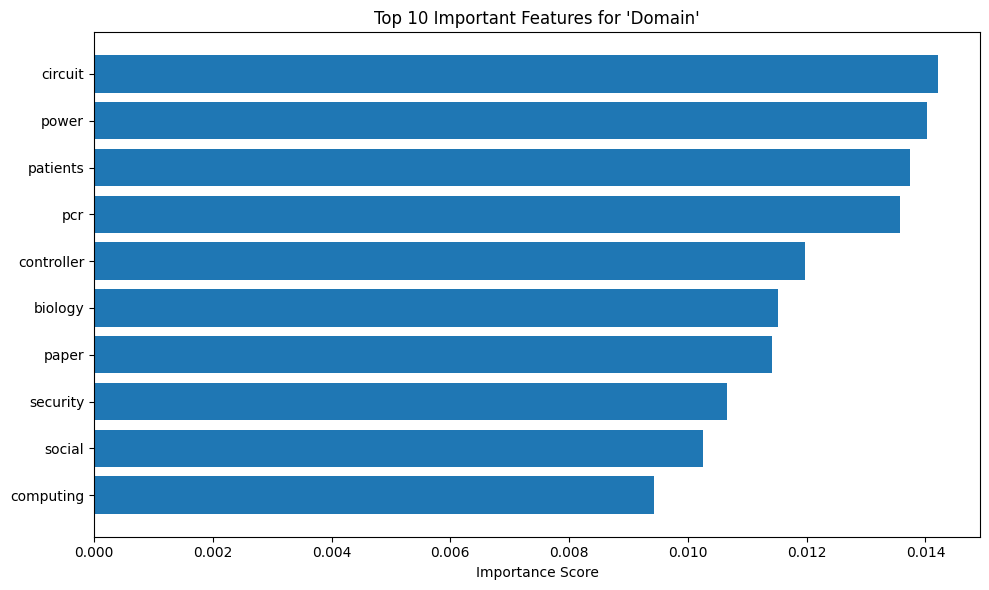

In [51]:
label_encoder = LabelEncoder()

# Run the best congfiguration, therefore concat train and validation sets
concat_train_df = pd.concat([train_df, val_df], ignore_index=True)

# Strip leading/trailing whitespace from labels
for df in [concat_train_df, test_df]:
    df["Domain"] = df["Domain"].str.strip()

# domain:
run_ngram_experiment((1, 2), concat_train_df, "-", test_df, label_encoder, "Domain")

In [12]:
label_encoder = LabelEncoder()

# Run the best congfiguration, therefore concat train and validation sets
concat_train_df = pd.concat([train_df, val_df], ignore_index=True)

# area:
run_ngram_experiment((1, 2), concat_train_df, "-", test_df, label_encoder, "area")


=== Evaluating on label column: 'area' | N-gram range: (1, 2) ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:43:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.8001
Test Classification Report:
                                    precision    recall  f1-score   support

                       Addiction         0.76      0.61      0.67        46
                Algorithm design         0.80      0.75      0.77        55
                       Allergies         1.00      0.89      0.94        53
             Alzheimer's Disease         0.75      0.80      0.77        55
            Ambient Intelligence         0.72      0.75      0.73        55
        Analog signal processing         0.81      0.85      0.83        59
          Ankylosing Spondylitis         0.67      0.60      0.63        40
 Antisocial personality disorder         0.93      0.83      0.88        47
                         Anxiety         0.45      0.48      0.47        42
                          Asthma         0.73      0.69      0.71        52
               Atopic Dermatitis         0.70      0.52      0.60        44
             Atrial Fibrillation     

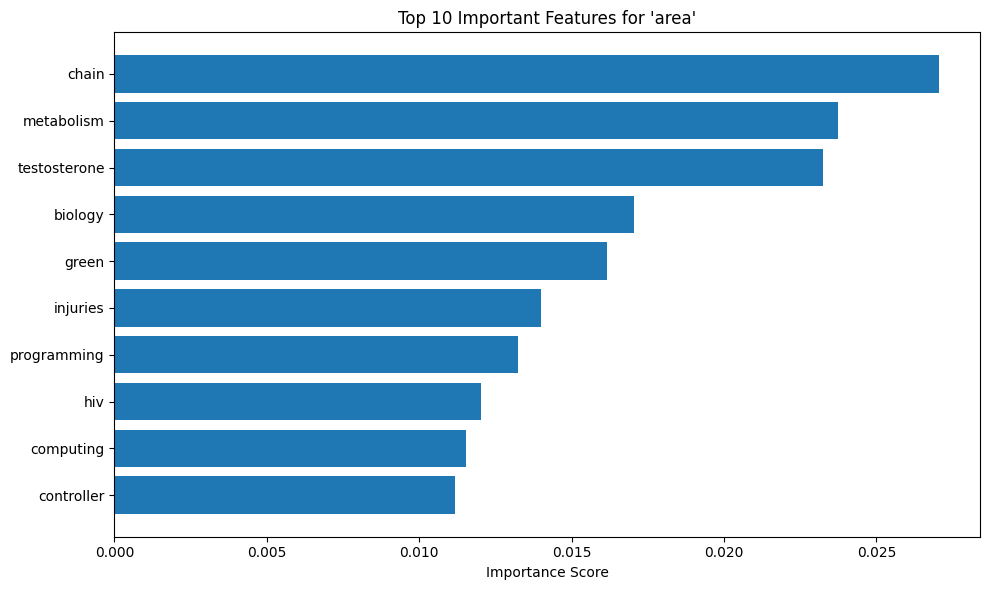

In [52]:
label_encoder = LabelEncoder()

# Run the best congfiguration, therefore concat train and validation sets
concat_train_df = pd.concat([train_df, val_df], ignore_index=True)

# Strip leading/trailing whitespace from labels
for df in [concat_train_df, test_df]:
    df["area"] = df["area"].str.strip()

# domain:
run_ngram_experiment((1, 2), concat_train_df, "-", test_df, label_encoder, "area")

### Visualization:

In [27]:
df_domain = pd.read_csv("/content/classification_report_domain.csv")
df_area = pd.read_csv("/content/classification_report_area.csv")

In [47]:
df_domain = df_domain[~df_domain["Label"].isin(["macro avg", "weighted avg"])]

In [48]:
df_area = df_area[~df_area["Label"].isin(["macro avg", "weighted avg"])]

In [49]:
df_domain

,Label,Precision,Recall,F1-Score,Support
0,CS,0.92,0.94,0.93,970
1,Civil,0.94,0.89,0.91,633
2,ECE,0.94,0.93,0.93,807
3,MAE,0.94,0.85,0.89,494
4,Medical,0.86,0.92,0.89,2166
5,Psychology,0.88,0.83,0.85,1072
6,biochemistry,0.89,0.85,0.87,851


In [50]:
df_area

,Label,Precision,Recall,F1-Score,Support
0,Addiction,0.76,0.61,0.67,46.0
1,Algorithm design,0.80,0.75,0.77,55.0
2,Allergies,1.00,0.89,0.94,53.0
3,Alzheimer's Disease,0.75,0.80,0.77,55.0
4,Ambient Intelligence,0.72,0.75,0.73,55.0
...,...,...,...,...,...
125,Thermodynamics,0.75,0.85,0.80,62.0
126,Water Pollution,0.85,0.83,0.84,77.0
127,Weight Loss,0.85,0.88,0.87,60.0
128,computer-aided design,0.87,0.78,0.82,51.0


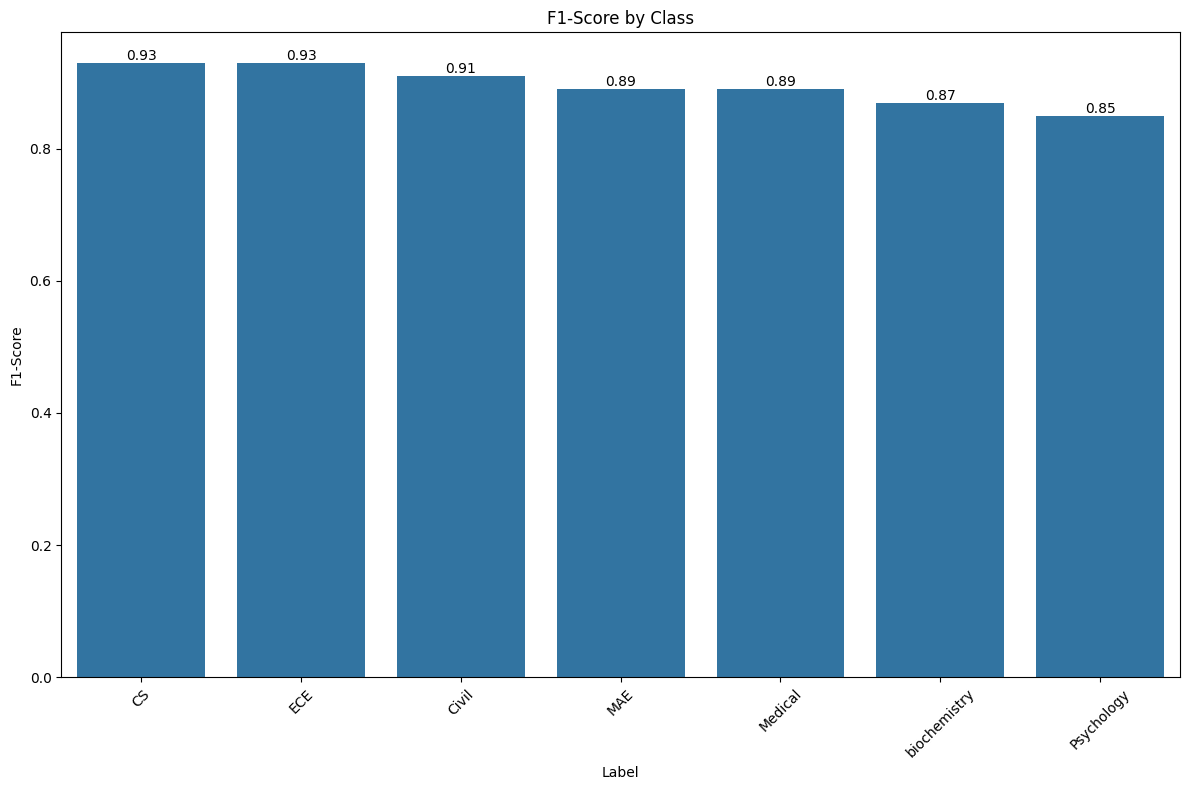

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

for df in [df_domain]:
    df = df[~df["Label"].isin(["macro avg", "weighted avg"])]
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df, x="Label", y="F1-Score", order=df.sort_values("F1-Score", ascending=False)["Label"])
    plt.title("F1-Score by Class")
    plt.xticks(rotation=45)

    # This uses Matplotlib 3.4+ functionality
    ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')

    plt.tight_layout()
    plt.show()


In [44]:
# Sort by F1 and plot
top = df_area.sort_values("F1-Score", ascending=False).head(15)
bottom = df_area.sort_values("F1-Score").head(15)


<Axes: xlabel='Support', ylabel='F1-Score'>

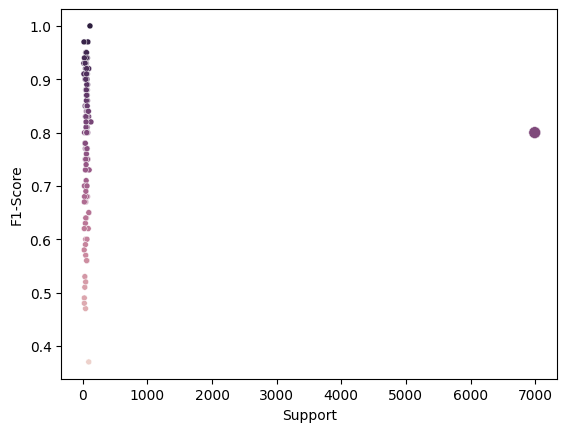

In [46]:
# Bubble chart: size ~ support
sns.scatterplot(data=df_area, x="Support", y="F1-Score", size="Support", hue="F1-Score", legend=False)


In [53]:
df = pd.read_excel("/content/Data.xlsx")
df["area"].nunique()


143